# Install Required Packages

In [1]:
!pip install -q scikit-learn tensorflow pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

2025-08-04 22:29:34.726473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754321374.820690    5474 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754321374.849624    5474 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754321375.052248    5474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754321375.052284    5474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754321375.052288    5474 computation_placer.cc:177] computation placer alr

# Load and Preprocess Train Data

In [3]:
df = pd.read_csv("../data/Train_augmented.csv", engine="python")
df['Query'] = df['Query'].astype(str).str.lower().str.strip()
df = df.drop_duplicates()
df = df.dropna(subset=["Label"])

print("Train label distribution:", df["Label"].value_counts().to_dict())

Train label distribution: {0.0: 46676, 1.0: 46634}


# SQL Tokenizer

In [4]:
def sql_tokenize(query):
    return re.findall(r"[a-zA-Z_]+|[0-9]+|['\"].*?['\"]|[^\s\w]", query)

df["tokens"] = df["Query"].apply(sql_tokenize)
df["joined_tokens"] = df["tokens"].apply(lambda x: " ".join(x))

# Tokenize & Pad

In [5]:
VOCAB_SIZE = 2000
MAX_LEN = 64
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["joined_tokens"])

X_train_seq = tokenizer.texts_to_sequences(df["joined_tokens"])
X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
y_train = df["Label"].astype(int).values

# Load Test Data

In [6]:
test_df = pd.read_csv("../data/Test_augmented.csv")
test_df['Query'] = test_df['Query'].astype(str).str.lower().str.strip()
test_df = test_df.dropna(subset=["Label"])
test_df["tokens"] = test_df["Query"].apply(sql_tokenize)
test_df["joined_tokens"] = test_df["tokens"].apply(lambda x: " ".join(x))
X_test_seq = tokenizer.texts_to_sequences(test_df["joined_tokens"])
X_test = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post")
y_test = test_df["Label"].astype(int).values

print("Test label distribution:", test_df["Label"].value_counts().to_dict())

Train label distribution: {1.0: 15494, 0.0: 15494}


# Training Model

In [7]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    Conv1D(64, 3, activation="relu"),
    MaxPooling1D(pool_size=2),
    GRU(64),
    Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32,
          class_weight=class_weights, callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

/home/bz/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1754321389.366914    5474 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4126 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/10


I0000 00:00:1754321391.740850    6196 cuda_dnn.cc:529] Loaded cuDNN version 91002


2916/2916 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9282 - loss: 0.1850 - val_accuracy: 0.9713 - val_loss: 0.0860
Epoch 2/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9760 - loss: 0.0724 - val_accuracy: 0.9730 - val_loss: 0.0813
Epoch 3/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9781 - loss: 0.0638 - val_accuracy: 0.9731 - val_loss: 0.0846
Epoch 4/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9807 - loss: 0.0524 - val_accuracy: 0.9728 - val_loss: 0.0903
Epoch 5/10
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9834 - loss: 0.0446 - val_accuracy: 0.9698 - val_loss: 0.0979


# Evaluation on Test.csv

969/969 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Evaluation on Test.csv
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     15494
           1       0.99      0.95      0.97     15494

    accuracy                           0.97     30988
   macro avg       0.97      0.97      0.97     30988
weighted avg       0.97      0.97      0.97     30988

[[15403    91]
 [  745 14749]]


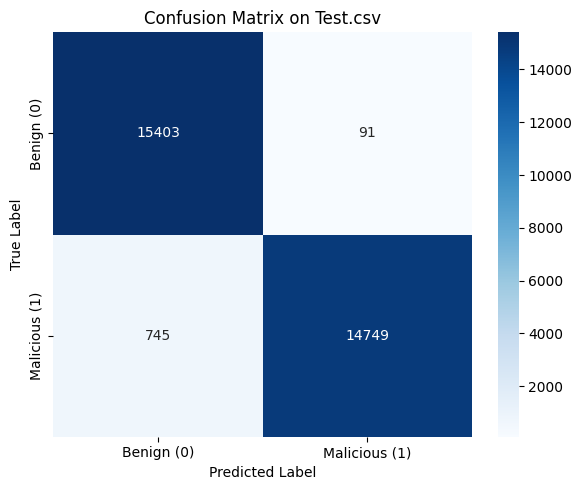

In [8]:
y_test_pred = model.predict(X_test).round()
print("Evaluation on Test.csv")
print(classification_report(y_test, y_test_pred))
# print(confusion_matrix(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)

print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Benign (0)", "Malicious (1)"],
            yticklabels=["Benign (0)", "Malicious (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test.csv")
plt.tight_layout()
plt.show()

# Evaluation on Validation.csv

In [9]:
eval_df = pd.read_csv("../data/Validation_augmented.csv")
eval_df['Query'] = eval_df['Query'].astype(str).str.lower().str.strip()
eval_df = eval_df.dropna(subset=["Label"])
eval_df["tokens"] = eval_df["Query"].apply(sql_tokenize)
eval_df["joined_tokens"] = eval_df["tokens"].apply(lambda x: " ".join(x))
X_eval_seq = tokenizer.texts_to_sequences(eval_df["joined_tokens"])
X_eval = pad_sequences(X_eval_seq, maxlen=MAX_LEN, padding="post")
y_eval = eval_df["Label"].astype(int).values

y_eval_pred = model.predict(X_eval).round()
print("Evaluation on Validation.csv")
print(classification_report(y_eval, y_eval_pred))
print(confusion_matrix(y_eval, y_eval_pred))

974/974 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Evaluation on Validation.csv
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     15572
           1       0.99      0.95      0.97     15572

    accuracy                           0.97     31144
   macro avg       0.97      0.97      0.97     31144
weighted avg       0.97      0.97      0.97     31144

[[15460   112]
 [  837 14735]]


# Save Model for Implementation

In [10]:
model.save("../models/cnn_gru_model.keras")

import pickle
with open("../models/tokenizer.pkl", "wb") as f:
   pickle.dump(tokenizer, f)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 64, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 62, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 916,997 (3.50 MB)

 Trainable params: 305,665 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 611,332 (2.33 MB)